# Sensitivity analysis

Extensisq contains a couple functions to help with sensitivity analysis of an ODE solution to initial values or parameters. This can be useful for finding periodic solutions, data fitting, or for solving boundary value problems using a shooting method. This notebook demonstrates these functions: `sensitivity`, `sensitivity_y0` and `find_periodic_solution`.

The theory and the first example can be found in the book of [Hairer](https://doi.org/10.1007/978-3-540-78862-1) under "internal differentiation".

## General sensitivity problem (demo `sensitivity`)

The general problem with a scalar real parameter $B$ is:
$$ \dot{\bm{y}} = \bm{f}(t, \bm{y}, B), \qquad \bm{y}(t_0) = \bm{y_0}(B) $$

As example, we use the Brusselator problem of Hairer, integrated from $t_0 = 0$ to $t_f = 20$:

In [16]:
t_span = [0., 20.]
B = 3.08

def fun(x, y, B):
    y1, y2 = y
    f1 = 1 + y1**2 * y2 - (B + 1) * y1
    f2 = B * y1 - y1**2 * y2
    return [f1, f2]

y0 = [1.3, B]

The sensitivity that we are looking for is:
$$\bm{\Phi} = \frac{\partial \bm{y}}{\partial B} $$

for a nominal value of $B=3.08$.

The sensitivity $\bm{\Phi}$ can be found by integration of another initial value problem:
$$\dot{\bm{\Phi}} = \frac{\partial \bm{f}}{\partial \bm{y}}\bm{\Phi} + \frac{\partial \bm{f}}{\partial B}, \qquad \bm{\Phi_0} = \frac{\partial \bm{y_0}}{\partial B} $$

In which $ \frac{\partial \bm{f}}{\partial \bm{y}}\bm{\Phi} $ is the matrix-vector product between the Jacobian of the original problem and the sensitivity solution.

So we need this Jacobian, and the derivative of the derivative function to the parameter $B$. Both are functions with signature (t, y, B). Furthermore, we need the initial value $\frac{\partial \bm{y_0}}{\partial B}$, which depends on parameter $B$ in general (which is a constant).  

In [17]:
def jac(x, y, B):
    y1, y2 = y
    df1dy1 = 2 * y1 * y2 - (B + 1)
    df1dy2 = y1**2
    df2dy1 = B - 2 * y1 * y2
    df2dy2 = -y1**2
    return [[df1dy1, df1dy2], [df2dy1, df2dy2]]

def dfdB(x, y, B):
    y1, y2 = y
    df1dB = -y1
    df2dB = y1
    return [df1dB, df2dB]

dy0dB = [0., 1.]

The original problem and the sensitivity problem are integrated together. Extensisq contains the `sensitivity` function to help with this.

In [18]:
from extensisq import *

sens, yf, full_sol = sensitivity(fun, t_span, y0, jac, B, dfdB, dy0dB)

print('sensitivity:', sens)
print('final solution:', yf)
print(full_sol.y[:, -1])

sensitivity: [-0.53694749  0.01099699]
final solution: [0.43845554 4.59110597]
[ 0.43845554  4.59110597 -0.53694749  0.01099699]


We have calculated the sensitivity at the end of the integration $\bm{\Phi}(t_f) = \frac{\partial \bm{y}}{\partial B}(t_f)$ and the solution itself at this point in time $\bm{y}(t_f)$. The function also returns the OdeResult object of the integration. As you can see this contains the concatenated results of both the original problem and the sensitivity problem.

We could take a look at how the result varies over time.


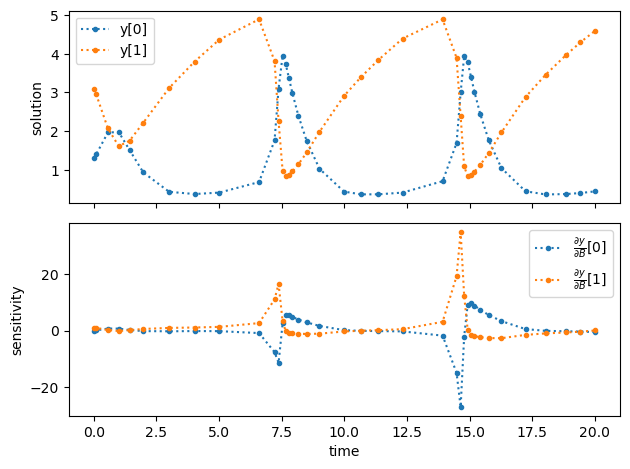

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(full_sol.t, full_sol.y[:2, :].T, '.:')
axs[1].plot(full_sol.t, full_sol.y[2:, :].T, '.:')
axs[1].set_xlabel('time')
axs[0].set_ylabel('solution')
axs[1].set_ylabel('sensitivity')
axs[0].legend(['y[0]', 'y[1]'])
axs[1].legend([r'$\frac{\partial y}{\partial B}[0]$', 
               r'$\frac{\partial y}{\partial B}[1]$'])
plt.tight_layout()
plt.show()

Neither the solution nor the sensitivity are smooth.

### Validation

Hairer shows a figure in his book with some result of this problem for a few different values of B. This result can serve as a kind of validation of the `sensitivity` function. Let's try to reproduce it.

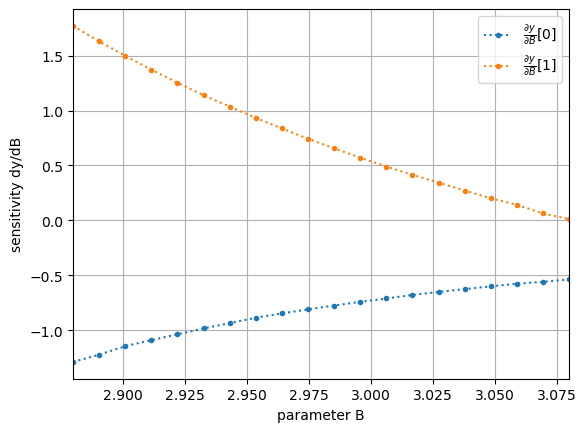

In [20]:
import numpy as np

results = []
Bs = np.linspace(2.88, 3.08, 20)
for B in Bs:
    y0 = [1.3, B]
    dy0dB = [0., 1.]    # not dependent on B in this case
    _sens, _, _ = sensitivity(fun, t_span, y0, jac, B, dfdB, dy0dB)
    results.append(_sens)

plt.plot(Bs, results, '.:')
plt.grid()
plt.xlim(Bs[0], Bs[-1])
plt.xlabel("parameter B")
plt.ylabel("sensitivity dy/dB")
plt.legend([r'$\frac{\partial y}{\partial B}[0]$', 
            r'$\frac{\partial y}{\partial B}[1]$'])
plt.show()

This figure resembles Hairer's figure quite well.

### Options

The `sensitivity` function has similar options as the `solve_ivp` function. The default solver is `BS5`, and `atol` and `rtol` have the same default values as in `solve_ivp`. The `vectorized` argument is ignored. Furthermore, the `sensitivity` function only makes most sense for explicit integrations methods, because we do not have an analytic Jacobian of the extended problem. A warning is issued if one of scipy's implicit methods is selected.

In [21]:
sens, _, _ = sensitivity(fun, t_span, y0, jac, B, dfdB, dy0dB, method='BDF')
print(sens)

[-0.54954329 -0.01229509]


(The result is not bad in this case.)

## Sensitivity for initial conditions (demo `sensitivity_y0`)

The sensitivity problem simplifies if only the sensitivity for initial conditions are needed. Therefore, I added a function `sensitivity_y0` to Extensisq. It calculate the sensitivity to all initial values at once. This does create a relatively large problem of n*(n+1) equations, where the original problem has n equations.

Let's apply it to the Brusselator problem

In [22]:
sens_y0, _, _ = sensitivity_y0(fun, t_span, y0, jac, args=(B, ))
print(sens_y0)

[[ 0.05160096 -0.0388647 ]
 [ 0.25767075 -0.19407193]]


### Validate

The same result could also be calculated by calling `sensitivity` twice. This serves as a simple validation of the `sensitivity_y0` function.

In [23]:
def dfdB_y0(x, y, B):
    """"Return 0 for initial value problem sensitivity"""
    return np.zeros_like(y)

dy0dB_0 = [1., 0.]
sens0, _, _ = sensitivity(fun, t_span, y0, jac, B, dfdB_y0, dy0dB_0)
dy0dB_1 = [0., 1.]
sens1, _, _ = sensitivity(fun, t_span, y0, jac, B, dfdB_y0, dy0dB_1)
sens_val = np.stack((sens0, sens1)).T
print(sens_val)

[[ 0.05080615 -0.03860863]
 [ 0.25398288 -0.19295764]]


Which is quite close to the result above. The results are not identical, because different problems are solved with different step times chosen by the solver. If this is a problem, then it could be mitigated by reducing the tolerances.

## Periodic solutions (demo `find_periodic_solution`)

As mentioned in the beginning of this notebook, one of the applications for sensitivity analysis is to find periodic solutions. This involves calling the `sensitivity_y0` iteratively in a Newton Raphson loop. Extensisq's function `find_periodic_solution` does exactly this. It does need initial a first guess of the initial conditions that is quite close to those of the periodic solution. Let's have some fun with this.

### Duffing's equation

Duffing's equation describes a non-linear mass spring system, excited by a sinusoidal force with ODE:

$$ \ddot{u} + \delta \dot{u} + \alpha u + \beta u^3 = \gamma \sin (\omega t) $$

The initial value problem needs initial conditions $u_0$ and $\dot{u}$. We will solve it as a first order ODE using $y = \{ u, \dot{u} \}^T$. We need the derivative function and the Jacobian function (for the sensitivity calculations):

In [24]:
def fun_duffing(t, y, alpha, beta, gamma, delta, omega):
    return [y[1],
            -delta*y[1] - beta*y[0]**3 - alpha*y[0] + gamma*np.sin(omega*t)]

def jac_duffing(t, y, alpha, beta, gamma, delta, omega):
    return [[0., 1.],
            [-3*beta*y[0]**2 - alpha, -delta]]

# duffing coefficients
alpha = 1.          # linear spring constant
beta = -1/6         # cubic spring constant
gamma = 4.          # excitation amplitude
delta = 0.          # damping constant
omega = 2.78535     # excitation frequency (angular)
args = (alpha, beta, gamma, delta, omega)

T = 2*np.pi/omega   # excitation period
print('T:', T)

T: 2.255797406853568


Here we use a softening spring (negative $\beta$) and no damping ($\delta = 0$). Because we have no damping, we cannot find a periodic solution by using a very long integration interval. Some experimentation (using a little damping) results in an interesting initial value estimate of $y_0 = [0, -2.6]$.

First, we will solve this problem for a relatively long interval and make a phase plot ($u$ versus $\dot{u}$) of the continuous result and the discrete results at each period (using `t_eval`).

integration success: True
nr of fun evals: 987


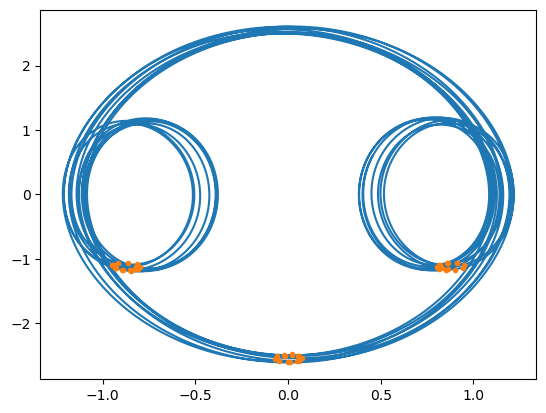

In [25]:
from scipy.integrate import solve_ivp

y0 = [0., -2.6]                 # initial guess for periodic solution
t_span = [0, 100]               # long interval to find periodicity
t_eval = np.arange(*t_span, T)  # output each excitation period

sol = solve_ivp(fun_duffing, t_span, y0, args=args, dense_output=True,
                t_eval=t_eval, method=BS5, interpolant='free')
print('integration success:', sol.success)
print('nr of fun evals:', sol.nfev)

t = np.linspace(50, 100, 10000)
plt.plot(*sol.sol(t))
plt.plot(*sol.y, '.')
plt.show()

Note that the method `BS5` is used for efficiency.

The phase portrait has an interesting shape, and the grouping of the dots (Poincaré map) suggests that we are dealing with a 1/3rd harmonic response.

Next, we will try to find accurate initial values for the periodic solution that I think we are seeing. 

In [26]:
res = find_periodic_solution(fun_duffing, [0, 3*T], y0, jac_duffing, args=args,
                             rtol=1e-6, method=CFMR7osc, dense_output=True)

print('Newton Raphson converged:', res.opt_success)
print('Nr of Newton Raphson updates:', res.opt_nit)
print('Found initial value:', res.opt_y0)
print('Remaining residual:', res.opt_residual)

Newton Raphson converged: True
Nr of Newton Raphson updates: 3
Found initial value: [-2.02620491e-07 -2.55316182e+00]
Remaining residual: [3.53684007e-09 4.19109369e-09]


Here, the relative tolerance was lowered, and the method `CFMR7osc` was used. This method is very good for oscillatory problems. Notice that the interval t_span is [0, 3*T], because we are expecting a 1/3rd harmonic solution.

The returned object contains the results of the Newton Raphson iteration (attributes with prefix 'opt_'). T also contains the results from the last solved initial value problem. We can use this to plot the periodic solution. (This is why `dense_output` was set to True). (The solution also contains the n*n components of $\Phi$.)

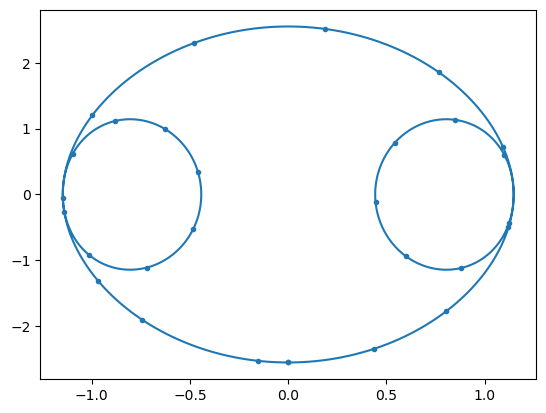

In [27]:
tp = np.linspace(0, 3*T, 1000)
plt.plot(res.sol(tp)[0, :], res.sol(tp)[1, :])
plt.plot(res.y[0, :], res.y[1, :], 'C0.')
plt.show()

This shows the periodic solution that we expected.

During some test, I found another initial value that seems to lead to a (little boring) solution without subharmonic.

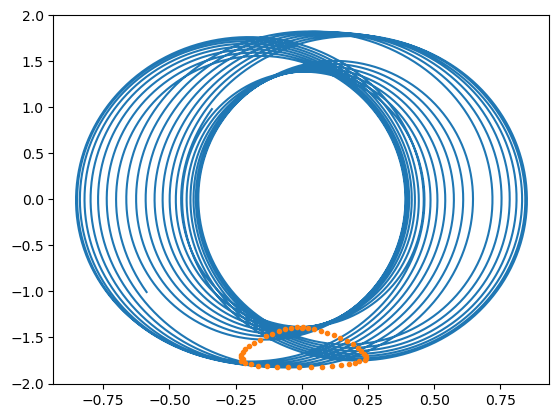

In [28]:
y0 = [0., -1.4]     # initial guess for periodic solution
res2 = solve_ivp(fun_duffing, t_span, y0, args=args, dense_output=True,
                 t_eval=t_eval, method=BS5, interpolant='free')

plt.plot(*res2.sol(t))
plt.plot(*res2.y, '.')
plt.show()

Notice that only the initial value was changed and none of the other parameters.

Let's see if we can find the initial value for this periodic solution too.

In [29]:
res2 = find_periodic_solution(fun_duffing, [0, T], y0, jac_duffing, args=args,
                              rtol=1e-6, method=CFMR7osc, dense_output=True)

print('Newton Raphson converged:', res2.opt_success)
print('Nr of Newton Raphson updates:', res2.opt_nit)
print('Found initial value:', res2.opt_y0)
print('Remaining residual:', res2.opt_residual)

Newton Raphson converged: True
Nr of Newton Raphson updates: 3
Found initial value: [-7.33857406e-09 -1.63913196e+00]
Remaining residual: [4.07755214e-12 1.01394448e-11]


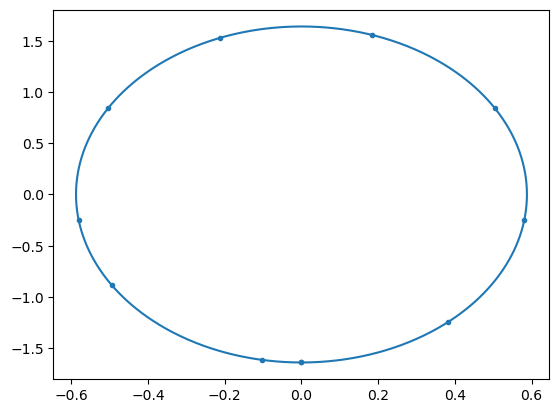

In [30]:
tp2 = np.linspace(0, T, 1000)
plt.plot(res2.sol(tp2)[0, :], res2.sol(tp2)[1, :])
plt.plot(res2.y[0, :], res2.y[1, :], 'C0.')
plt.show()

The integration interval t_span is now reduced to [0, T]. Again, the expected periodic solution was found after 3 Newton Raphson iterations.

### Discussion

The function `find_periodic_solution` seems to work well to find the initial values for a periodic solution, if a good estimate of these initial conditions (and the correct integration interval of one period) are given. The periodic solution itself is also returned (including the sensitivity components $\Phi$). A non-linear problem is not guaranteed to have a periodic solution, and if it does have one, that solution is not guaranteed to be stable. None of these things are checked. `find_periodic_solution` is only a Newton Raphson iteration around `sensitivity_y0`.  